In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
import re

In [5]:

# Canonical mapping: internal name → list of possible user-provided names
expected_features = {
    'churn_flag': ['churn', 'churn_flag', 'Churn Flag', 'Churn_Flag', 'CHURN FLAG'],
    'credit_score': ['credit score', 'creditscore', 'Credit_Score'],
    'balance': ['balance', 'Balance'],
    'num_products': ['NumOfProducts', 'num_products', 'number of products'],
    'income': ['income', 'annual income', 'Income'],
    'customer_tenure': ['Customer Tenure', 'tenure', 'Tenure', 'Years with Bank'],
    'outstanding_loans': ['Outstanding Loans', 'loans', 'loan_balance'],
    'credit_history_length': ['Credit History Length', 'history length'],
    'num_complaints': ['NumComplaints', 'complaints'],
}

required_model_features = [
    'credit_score', 'customer_tenure', 'balance',
    'num_products', 'outstanding_loans', 'income',
    'credit_history_length', 'num_complaints'
]

training_feature_order = [
    'Credit Score', 'Customer Tenure', 'Balance Band Encoded',
    'NumOfProducts', 'Outstanding Loans Band Encoded', 'Income Band Encoded',
    'Credit History Length', 'NumComplaints'
]


In [6]:

# Normalize column names (lowercase, no punctuation)
def normalize_column(col):
    return re.sub(r'[^a-z0-9]', '', col.lower())

def map_columns(df, expected_features):
    norm_user_cols = {normalize_column(c): c for c in df.columns}
    mapped = {}
    for key, variations in expected_features.items():
        for v in variations:
            norm_v = normalize_column(v)
            if norm_v in norm_user_cols:
                mapped[key] = norm_user_cols[norm_v]
                break
    return df.rename(columns={v: k for k, v in mapped.items()})


In [7]:

# Load saved encoders and bin edges
le_income = joblib.load('le_income.pkl')
le_balance = joblib.load('le_balance.pkl')
le_outstanding = joblib.load('le_outstanding.pkl')
income_bins = joblib.load('income_bins.pkl')
balance_bins = joblib.load('balance_bins.pkl')
outstanding_bins = joblib.load('outstanding_bins.pkl')

In [8]:
def predict_churn(uploaded_csv_path, model_path, scaler_path, output_path,
                  income_bins, balance_bins, outstanding_bins,
                  le_income, le_balance, le_outstanding):
    
    # Load and map user data
    user_df = pd.read_csv(uploaded_csv_path)
    clean_df = map_columns(user_df, expected_features)

    # Check for required columns
    missing = [col for col in required_model_features if col not in clean_df.columns]
    if missing:
        raise ValueError(f"Missing required features for prediction: {missing}")
       
    # Binning
    clean_df['income_band'] = pd.cut(clean_df['income'], bins=income_bins, labels=le_income.classes_, include_lowest=True)
    clean_df['balance_band'] = pd.cut(clean_df['balance'], bins=balance_bins, labels=le_balance.classes_, include_lowest=True)
    clean_df['outstanding_loans_band'] = pd.cut(clean_df['outstanding_loans'], bins=outstanding_bins, labels=le_outstanding.classes_, include_lowest=True)

    # Encoding
    clean_df['income_band_encoded'] = le_income.transform(clean_df['income_band'])
    clean_df['balance_band_encoded'] = le_balance.transform(clean_df['balance_band'])
    clean_df['outstanding_loans_band_encoded'] = le_outstanding.transform(clean_df['outstanding_loans_band'])

    # 📊 Customer Analysis Visualizations
    print("📊 Showing customer insights...")

    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=clean_df, x='income', y='balance', alpha=0.3, s=10)
    plt.title("💰 Income vs. Account Balance")
    plt.tight_layout()
    plt.show()

    if 'num_products' in clean_df.columns:
        plt.figure(figsize=(5, 4))
        sns.countplot(data=clean_df, x='num_products')
        plt.title("🛍 Number of Products per Customer")
        plt.tight_layout()
        plt.show()

    if 'outstanding_loans' in clean_df.columns:
        plt.figure(figsize=(5, 4))
        sns.histplot(data=clean_df, x='outstanding_loans', bins=30, kde=True)
        plt.title("🏦 Outstanding Loan Amounts")
        plt.tight_layout()
        plt.show()

    if 'income_band' in clean_df.columns:
        plt.figure(figsize=(5, 4))
        sns.countplot(data=clean_df, x='income_band', order=le_income.classes_)
        plt.title("📊 Income Band Distribution")
        plt.tight_layout()
        plt.show()

    if 'num_complaints' in clean_df.columns and 'income_band' in clean_df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=clean_df, x='income_band', y='num_complaints', order=le_income.classes_)
        plt.title("😠 Complaints by Income Band")
        plt.tight_layout()
        plt.show()

    # Build and rename features
    X = clean_df[[
        'credit_score', 'customer_tenure', 'balance_band_encoded',
        'num_products', 'outstanding_loans_band_encoded', 'income_band_encoded',
        'credit_history_length', 'num_complaints'
    ]].copy()
    X.columns = training_feature_order

    # Scale
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X)

    # Predict
    model = joblib.load(model_path)
    clean_df['churn_prediction'] = model.predict(X_scaled)
    clean_df['churn_probability'] = model.predict_proba(X_scaled)[:, 1]

    # Save
    clean_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")
    print(clean_df[['churn_prediction', 'churn_probability']].head())


📊 Showing customer insights...


/var/folders/kd/_cc1wqms2wl_9ljpqgc6vs8h0000gn/T/ipykernel_2203/2681825446.py:30: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  plt.tight_layout()
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


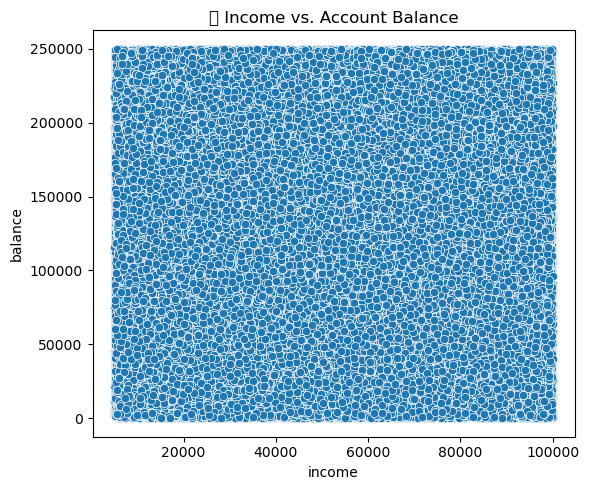

/var/folders/kd/_cc1wqms2wl_9ljpqgc6vs8h0000gn/T/ipykernel_2203/2681825446.py:37: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from current font.
  plt.tight_layout()
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


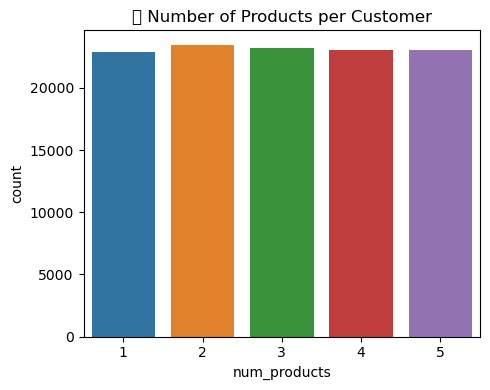

/var/folders/kd/_cc1wqms2wl_9ljpqgc6vs8h0000gn/T/ipykernel_2203/2681825446.py:44: UserWarning: Glyph 127974 (\N{BANK}) missing from current font.
  plt.tight_layout()
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127974 (\N{BANK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


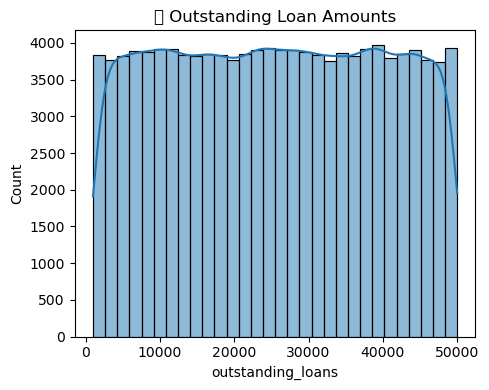

/var/folders/kd/_cc1wqms2wl_9ljpqgc6vs8h0000gn/T/ipykernel_2203/2681825446.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


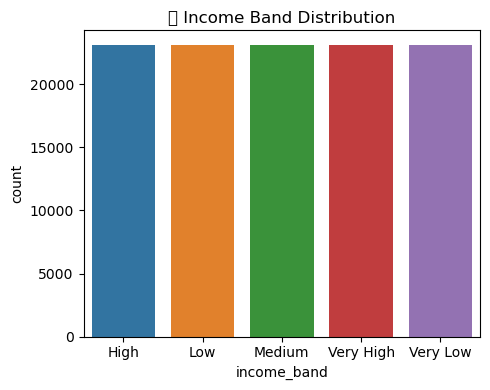

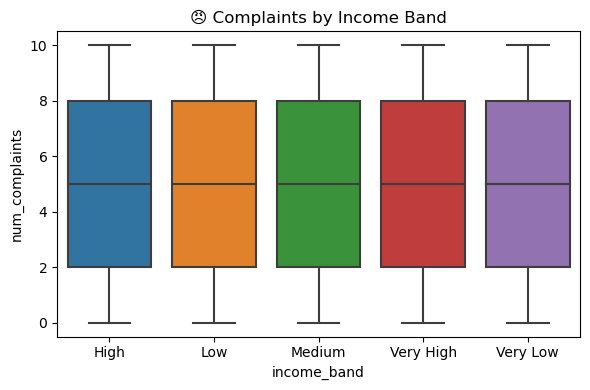

/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Prediction results saved to: prediction_output.csv
   churn_prediction  churn_probability
0                 1           0.975755
1                 0           0.000061
2                 0           0.000426
3                 0           0.079265
4                 0           0.002039


In [9]:

predict_churn(
    uploaded_csv_path='/Users/pyaekyitharchaw/Documents/CSCT Project/Data/botswana_bank_customer_churn.csv',
    model_path='lgbm_churn_model.pkl',
    scaler_path='scaler.pkl',
    output_path='prediction_output.csv',
    income_bins=joblib.load('income_bins.pkl'),
    balance_bins=joblib.load('balance_bins.pkl'),
    outstanding_bins=joblib.load('outstanding_bins.pkl'),
    le_income=joblib.load('le_income.pkl'),
    le_balance=joblib.load('le_balance.pkl'),
    le_outstanding=joblib.load('le_outstanding.pkl')
)

In [11]:

check_output = pd.read_csv('prediction_output.csv')
check_output.head()


,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,income,...,num_products,num_complaints,income_band,balance_band,outstanding_loans_band,income_band_encoded,balance_band_encoded,outstanding_loans_band_encoded,churn_prediction,churn_probability
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,...,1,0,Very High,Very Low,Very Low,3,4,4,1,0.975755
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,...,4,1,Medium,High,High,2,0,0,0,0.000061
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,...,2,6,High,Medium,Very Low,0,2,4,0,0.000426
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,...,1,0,High,Very Low,Low,0,4,1,0,0.079265
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,...,5,6,Medium,Low,Very High,2,1,3,0,0.002039
